# Predicting Developer Compensation from the Stack Overflow Annual Developer Survey

### Introduction: Understanding Developer Compensation with Data Science

In today's fast-evolving tech landscape, understanding the factors that influence a developer's compensation is crucial for both employers and employees. Compensation isn't just a reflection of one's skills and experience; it's an intricate interplay of various factors ranging from geographical location and educational background to specific tech stacks and organizational roles. The Stack Overflow Annual Developer Survey, one of the most comprehensive datasets about developers globally, offers a unique lens through which we can analyze and predict developer compensation.

This project dives deep into the survey's rich dataset, aiming to categorize developers into distinct salary brackets. Through rigorous data preprocessing, exploratory analysis, and advanced machine learning techniques, we unravel the intricacies of developer compensation. Join us as we embark on this analytical journey, navigating the challenges of real-world data and uncovering insights that could reshape our understanding of the tech industry's compensation dynamics.

let's start by examining the dataset to determine its features and potential classification strategies. First, we'll take a look at the first few rows and the overall structure of the data.

In [57]:
import pandas as pd

# Load the dataset
data = pd.read_csv("/Users/doris/Desktop/portafolio/Projects/classification/stack-overflow-developer-survey-2023/survey_results_public.csv")

# Display the first few rows and the overall structure of the dataset
data_head = data.head()
data_shape = data.shape
data_info = data.info()

data_head, data_shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

(   ResponseId     Q120                      MainBranch              Age  \
 0           1  I agree                   None of these  18-24 years old   
 1           2  I agree  I am a developer by profession  25-34 years old   
 2           3  I agree  I am a developer by profession  45-54 years old   
 3           4  I agree  I am a developer by profession  25-34 years old   
 4           5  I agree  I am a developer by profession  25-34 years old   
 
                                           Employment  \
 0                                                NaN   
 1                                Employed, full-time   
 2                                Employed, full-time   
 3                                Employed, full-time   
 4  Employed, full-time;Independent contractor, fr...   
 
                              RemoteWork  \
 0                                   NaN   
 1                                Remote   
 2  Hybrid (some remote, some in-person)   
 3  Hybrid (some remot

The dataset contains 89,184 entries with 84 columns. we first need to define our target variable. Compensation Level: Categorize developers into different salary brackets based on their skills, experience, and other attributes.
The next steps involved would be:

1. **Define Compensation Brackets:** We'll need to define the salary brackets or categories we want to classify respondents into. For instance: Low, Medium, High, or specific numerical ranges.

2. **Data Cleaning:** Address missing values and outliers, especially in the ConvertedCompYearly column which seems to represent the annual compensation.

3. **Feature Engineering:** Extract or derive new features that might influence compensation, such as years of experience, technologies known, or education level.

4. **Data Transformation:** Convert categorical variables into a format suitable for machine learning and normalize numerical features.

5. **Model Selection & Training:** Split the data, select an algorithm, train the model, and validate its performance.

6. **Evaluation:** Measure the performance of the model using appropriate metrics.

Let's first determine the range of the ConvertedCompYearly values to understand the spread and then replot the histogram with an appropriate bin size.

In [73]:
# Check the range of the ConvertedCompYearly values

import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values from the ConvertedCompYearly column for visualization
compensation_data = data['ConvertedCompYearly'].dropna()


compensation_min = compensation_data.min()
compensation_max = compensation_data.max()
compensation_median = compensation_data.median()

compensation_min, compensation_max, compensation_median


(1.0, 74351432.0, 74963.0)

The range for the ConvertedCompYearly values is quite large, from $\$1$ to over $\$74$ million. The median is approximately $\$75,000$. This wide range suggests the presence of outliers or potentially erroneous entries, which can distort the visualization.

To better visualize the distribution without extreme outliers, we can focus on a narrower range around the median. 

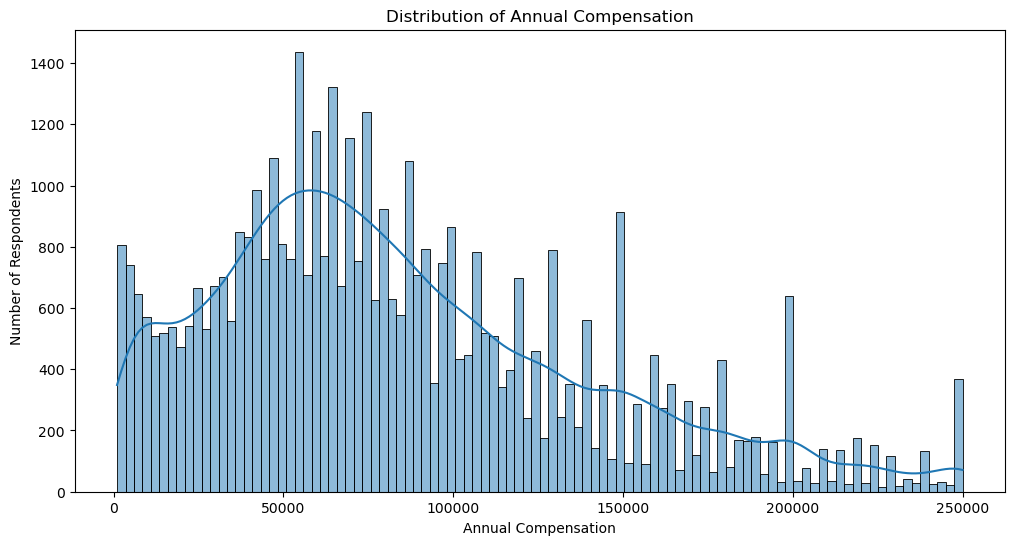

In [75]:
# Filtering the data to remove extreme outliers for visualization
filtered_compensation_data = compensation_data[(compensation_data >= 1000) & (compensation_data <= 250000)]

# Re-plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(filtered_compensation_data, bins=100, kde=True)
plt.title('Distribution of Annual Compensation')
plt.xlabel('Annual Compensation')
plt.ylabel('Number of Respondents')
plt.show()


The distribution of annual compensation is right-skewed, with many respondents in the lower compensation brackets and fewer in the higher ones.
To create meaningful classification brackets for "Compensation Level", we will use quantiles (percentiles):

**Low:** Compensation below the 25th percentile<br />
**Medium**: Compensation between the 25th and 75th percentiles<br />
**High:** Compensation above the 75th percentile.

## Step 1: Define Compensation Brackets

To classify respondents into compensation levels, we first need to define the boundaries of these levels. Using the data's distribution, we can employ quantiles (percentiles) to segment the data. This method ensures that each category will contain a roughly equal number of respondents, making our classification task more balanced.

Let's calculate the 25th and 75th percentiles to determine our "Low", "Medium", and "High" compensation brackets.

In [60]:
# Calculate the 25th and 75th percentiles for the compensation data

lower_bound = filtered_compensation_data.quantile(0.25)
upper_bound = filtered_compensation_data.quantile(0.75)

lower_bound, upper_bound


(44552.0, 117797.0)

## Step 2: Data Cleaning and Preparation

Before we can use the data for modeling, it needs to be cleaned and prepared. This includes handling missing values, encoding categorical variables, and creating our target variable based on the compensation brackets we've defined.

Let's create a new column, CompensationLevel, to represent our target variable. We'll then categorize each respondent into one of the three levels based on their ConvertedCompYearly value.

In [61]:
# Create the CompensationLevel column based on the defined brackets

data['CompensationLevel'] = pd.cut(data['ConvertedCompYearly'], 
                                   bins=[0, lower_bound, upper_bound, float('inf')], 
                                   labels=['Low', 'Medium', 'High'], 
                                   right=False)

# Check the distribution of the new CompensationLevel column
compensation_level_distribution = data['CompensationLevel'].value_counts(dropna=False)
compensation_level_distribution


NaN       41165
Medium    22846
High      13066
Low       12107
Name: CompensationLevel, dtype: int64

The distribution for the CompensationLevel column is as follows:

**NaN (Missing):** 41,165 entries<br />
**Medium Compensation:**  22,846 entries<br />
**High Compensation:**  13,066 entries<br />
**Low Compensation:**  12,107 entries<br />

The NaN values represent missing data in the ConvertedCompYearly column. For the purpose of classification, we will need to handle these missing values, either by imputing them or excluding them from our dataset.

## Step 3: Feature Selection and Engineering

In this step, we'll identify columns that could be relevant predictors for a respondent's compensation level. Features such as years of experience, country of residence, education level, and primary field of study are likely to influence compensation. Additionally, we might need to encode categorical features and normalize numerical ones to make them suitable for machine learning algorithms.

**3.1: Select Relevant Features**

Let's start by selecting a subset of columns that we believe could be relevant predictors. We'll also inspect these columns for any preliminary cleaning or transformation they might require.

In [62]:
# Selecting a subset of potentially relevant columns
selected_features = [
    'Country', 'Age', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'TechList'
]

# Extracting these columns from the dataset along with the target variable
subset_data = data[selected_features + ['CompensationLevel']].copy()

# Display the first few rows of the selected subset
subset_data_head = subset_data.head()

subset_data_head


,Country,Age,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,TechList,CompensationLevel
0,NaN,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States of America,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",18,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,Investigate,High
2,United States of America,45-54 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",27,23,"Developer, back-end","5,000 to 9,999 employees",Given a list,High
3,United States of America,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,7,"Developer, front-end",100 to 499 employees,Investigate,High
4,Philippines,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,4,"Developer, full-stack",20 to 99 employees,Investigate,Low


The table above presents the selected features, including 'Country', 'Age', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', and 'TechList'. Additionally, the CompensationLevel column classifies respondents' annual compensation into "Low", "Medium", or "High" categories based on the previously defined percentiles.

## 3.2: Handle Missing Values

Missing data can affect the performance of machine learning models. Different strategies can be used to handle missing values, such as imputation (filling in missing values) or removing rows with missing data. The choice of strategy often depends on the nature and amount of the missing data.

Let's start by checking for missing values in our selected features.

In [63]:
# Check for missing values in the subset_data
missing_values = subset_data.isnull().sum()

missing_values


Country               1211
Age                      0
EdLevel               1211
YearsCode             1749
YearsCodePro         23048
DevType              12312
OrgSize              24141
TechList             28333
CompensationLevel    41165
dtype: int64

Given the significant amount of missing data in certain columns, we need to decide on a strategy for each:

1. For columns like Country, EdLevel, and YearsCode with relatively fewer missing entries, we can either impute using a common strategy (like mode) or remove those rows.
2. For columns like YearsCodePro, DevType, OrgSize, and TechList with a more substantial amount of missing data, we might consider encoding the missing values as a separate category (e.g., "Unknown" or "Not Provided").
3. For the target column CompensationLevel, since we cannot impute the class labels without introducing bias, we should remove rows with missing values.

### 3.2.1: Impute or Remove Missing Values for Selected Columns

For columns with relatively fewer missing entries, we can either fill in the missing values or remove those specific rows. Given the data's nature, we'll use the mode (most frequent value) for categorical columns and median for numerical columns, as these are robust measures that are less influenced by outliers.

Let's start by imputing missing values for Country, EdLevel, and YearsCode.

In [64]:
# Convert textual representations to numeric values
subset_data['YearsCode'].replace({'Less than 1 year': '0', 'More than 50 years': '51'}, inplace=True)

# Convert the entire column to numeric datatype
subset_data['YearsCode'] = pd.to_numeric(subset_data['YearsCode'], errors='coerce')

# Impute missing values with median
subset_data['YearsCode'].fillna(subset_data['YearsCode'].median(), inplace=True)

# Check remaining missing values again
remaining_missing_values = subset_data.isnull().sum()

remaining_missing_values


Country               1211
Age                      0
EdLevel               1211
YearsCode                0
YearsCodePro         23048
DevType              12312
OrgSize              24141
TechList             28333
CompensationLevel    41165
dtype: int64

As seen in the updated missing values summary:

YearsCodePro, DevType, OrgSize, and TechList have substantial missing data. As discussed, we can consider encoding these missing values as a separate category, such as "Not Provided" or "Unknown".
We will handle the missing values in the target column CompensationLevel later by excluding those records from our dataset.


### 3.2.2: Encode Missing Values for Columns with Substantial Missing Data

For columns with a significant amount of missing data, introducing a new category like "Not Provided" or "Unknown" can be useful. This allows us to retain the records without introducing potential biases through imputation. The new category effectively becomes an additional feature for the model, capturing the absence of information.

In [65]:
# Encode missing values as "Not Provided"
columns_with_high_missing = ['YearsCodePro', 'DevType', 'OrgSize', 'TechList']
for col in columns_with_high_missing:
    subset_data[col].fillna('Not Provided', inplace=True)

# Check for any remaining missing values
remaining_missing_values = subset_data.isnull().sum()

remaining_missing_values


Country               1211
Age                      0
EdLevel               1211
YearsCode                0
YearsCodePro             0
DevType                  0
OrgSize                  0
TechList                 0
CompensationLevel    41165
dtype: int64

The missing values for YearsCodePro, DevType, OrgSize, and TechList have been successfully encoded as "Not Provided".


Considering the nature of the dataset (results from a survey), and the fact that the missing values in 'CompensationLevel' are likely not missing completely at random, we'll use a combination of techniques:

1. Impute the 'Country' and 'EdLevel' columns with the mode since they have a relatively smaller number of missing values.
2. Retain the rows where 'CompensationLevel' is not missing. 



In [66]:
# Impute 'Country' and 'EdLevel' with mode
subset_data['Country'].fillna(subset_data['Country'].mode()[0], inplace=True)
subset_data['EdLevel'].fillna(subset_data['EdLevel'].mode()[0], inplace=True)

# Retain rows where 'CompensationLevel' is not missing
subset_data = subset_data.dropna(subset=['CompensationLevel'])

# Check the remaining missing values
remaining_missing_values = subset_data.isnull().sum()
print(remaining_missing_values)


Country              0
Age                  0
EdLevel              0
YearsCode            0
YearsCodePro         0
DevType              0
OrgSize              0
TechList             0
CompensationLevel    0
dtype: int64


## 3.3: Encode Categorical Variables with Label Encoding

Label encoding involves converting each value in a column to a number. For example, in a column with values "Low", "Medium", and "High", label encoding might represent them as 0, 1, and 2, respectively. This method is quick and straightforward, but it does introduce an ordinal relationship that might not be present in the original data. This is something to be mindful of when using certain algorithms.

Let's proceed with label encoding the categorical columns in our dataset.

In [67]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
label_encoders = {}

# Encode categorical columns using label encoding
for col in subset_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    subset_data[col] = le.fit_transform(subset_data[col])
    label_encoders[col] = le  # Storing the encoder for potential inverse transformations later

# Display the first few rows of the encoded dataset
encoded_subset_data_head = subset_data.head()

encoded_subset_data_head


,Country,Age,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,TechList,CompensationLevel
1,163,1,1,18.0,49,31,4,1,High
2,163,3,1,27.0,15,11,6,0,High
3,163,1,1,12.0,47,14,3,1,High
4,119,1,1,6.0,33,15,5,1,Low
5,161,2,6,21.0,13,11,3,2,Medium


The categorical columns have been successfully label-encoded.


The table now presents the selected features with their encoded values. For example, the Country column has been transformed from country names to numerical labels. We've stored each label encoder in the label_encoders dictionary, allowing us to potentially reverse the encoding later if needed.

The next steps involve further feature engineering and data transformation to prepare our dataset for machine learning algorithms. This might include:

* Parsing the TechList column to create binary columns for each technology (if it has multiple entries separated by semicolons or other delimiters).
* Normalizing numerical features to ensure they're on a similar scale.
* Splitting the data into training and testing sets.


## 3.4: Feature Engineering and Transformation

Feature engineering involves creating new features or modifying existing ones to better represent the underlying patterns in the data. This step can significantly improve model performance.

For this dataset, the TechList column seems to contain multiple technologies separated by semicolons. We can create binary columns for each technology to better represent this data. Additionally, we'll normalize numerical columns to ensure they're on a similar scale.

### 3.4.1: Parse TechList Column
Let's start by parsing the TechList column and creating binary columns for each technology.

In [68]:
# Convert the 'TechList' column to string type
subset_data['TechList'] = subset_data['TechList'].astype(str)

# Parse the 'TechList' column to create binary columns for each technology
tech_dummies = subset_data['TechList'].str.get_dummies(sep=';')

# Drop the original 'TechList' column and append the new binary columns
subset_data = pd.concat([subset_data.drop('TechList', axis=1), tech_dummies], axis=1)

# Display the first few rows of the transformed dataset
transformed_subset_data_head = subset_data.head()

transformed_subset_data_head


,Country,Age,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,CompensationLevel,0,1,2,3
1,163,1,1,18.0,49,31,4,High,0,1,0,0
2,163,3,1,27.0,15,11,6,High,1,0,0,0
3,163,1,1,12.0,47,14,3,High,0,1,0,0
4,119,1,1,6.0,33,15,5,Low,0,1,0,0
5,161,2,6,21.0,13,11,3,Medium,0,0,1,0


The TechList column has been successfully parsed, and binary columns have been created for each technology.


The new binary columns represent different technologies that respondents have indicated familiarity with. Each column has a value of 1 if the respondent is familiar with that technology and 0 otherwise.

### 3.4.2: Normalize Numerical Features

Normalization is the process of scaling numeric features to have a mean of 0 and a standard deviation of 1. This ensures that all numeric features contribute equally to the performance of algorithms, especially those sensitive to feature scales like gradient descent-based methods or distance-based algorithms.

We'll use the StandardScaler from scikit-learn to normalize our numeric columns.


In [69]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_columns = subset_data.select_dtypes(include=['float64', 'int64']).columns

# Instantiate the scaler
scaler = StandardScaler()

# Normalize the numerical columns
subset_data[numerical_columns] = scaler.fit_transform(subset_data[numerical_columns])

# Display the first few rows of the normalized dataset
normalized_subset_data_head = subset_data.head()

normalized_subset_data_head


,Country,Age,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,CompensationLevel,0,1,2,3
1,1.080945,-0.535685,-0.673255,0.236892,1.422867,2.855297,0.164816,High,-0.242838,0.876247,-0.755165,-0.125364
2,1.080945,1.451803,-0.673255,1.148537,-0.449215,-0.590402,1.016917,High,4.117978,-1.141230,-0.755165,-0.125364
3,1.080945,-0.535685,-0.673255,-0.370872,1.312745,-0.073547,-0.261234,High,-0.242838,0.876247,-0.755165,-0.125364
4,0.287853,-0.535685,-0.673255,-0.978635,0.541888,0.098738,0.590867,Low,-0.242838,0.876247,-0.755165,-0.125364
5,1.044895,0.458059,2.080216,0.540774,-0.559337,-0.590402,-0.261234,Medium,-0.242838,-1.141230,1.324213,-0.125364


The table now presents the selected features with their normalized values. For example, the Country column has values around 0, which indicates they've been centered, and the standard deviation for these columns is now 1.

With normalization complete, the next step is to split the data into training and testing sets, ensuring we remove any rows with missing target values in CompensationLevel.

## 3.5: Splitting the Data into Training and Testing Sets

Splitting the dataset into training and testing sets allows us to train our machine learning models on one subset and evaluate their performance on another, unseen subset. This helps ensure that our models generalize well to new data and are not just fitting the training data too closely (overfitting).

Let's proceed with this step.

In [70]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = subset_data.drop('CompensationLevel', axis=1)
y = subset_data['CompensationLevel']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
train_test_shapes = {
    "X_train": X_train.shape,
    "X_test": X_test.shape,
    "y_train": y_train.shape,
    "y_test": y_test.shape
}

train_test_shapes


{'X_train': (38415, 11),
 'X_test': (9604, 11),
 'y_train': (38415,),
 'y_test': (9604,)}

This means we'll train our machine learning model on 38,415 samples and then evaluate its performance on 9,604 unseen samples.

With the data prepared, we can proceed to model training and evaluation. 



## 4.1: Model Training and Evaluation

Given that our target variable, CompensationLevel, is a categorical variable with three classes (Low, Medium, High), this is a multiclass classification problem. There are various algorithms suitable for multiclass classification, including:

1. Decision Trees
2. Random Forests
3. Gradient Boosting Machines
4. Logistic Regression (with multinomial setting)
5. Support Vector Machines (with appropriate kernel and settings)
6. Neural Networks

After training each model, we'll evaluate their performance on the test set and compare their metrics (like accuracy and F1-score) in a table.

By comparing the performance of different models, we can understand which models are best suited for our dataset and problem. This aids in model selection and provides insights into potential areas of improvement.

**1. Decision Trees**

Let's begin by training a Decision Tree classifier on our training data and evaluating its performance on the testing data.

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
dt_predictions = dt_classifier.predict(X_test)

# Evaluate the model's performance
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions, average='weighted')

dt_accuracy, dt_f1


(0.6213036234902124, 0.6213166556483987)

The accuracy represents the proportion of correctly classified instances out of the total instances. The F1-score is a measure that takes into account both precision (the number of correct positive results divided by the number of all positive results) and recall (the number of correct positive results divided by the number of positive results that should have been returned). The weighted average of the F1-score computes this metric for each label, and the result is then averaged, taking the number of true instances for each label into account.



**2. Random Forests**

Next, let's train a Random Forest classifier on our training data and evaluate its performance on the testing data.

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test data
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the model's performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')

rf_accuracy, rf_f1


(0.6883590170762183, 0.6866199005816039)

The Random Forest classifier, an ensemble method, shows an improvement in performance compared to the single Decision Tree.

**3. Gradient Boosting Machines (GBM)**

Next, let's train a Gradient Boosting classifier and evaluate its performance. Gradient Boosting is a powerful ensemble method that builds trees sequentially, where each tree tries to correct the mistakes of the previous one.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier on the training data
gbm_classifier.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = gbm_classifier.predict(X_test)

# Evaluate the model's performance
gbm_accuracy = accuracy_score(y_test, gbm_predictions)
gbm_f1 = f1_score(y_test, gbm_predictions, average='weighted')

gbm_accuracy, gbm_f1


(0.7098084131611828, 0.7081931800620362)

The GBM classifier, with its sequential tree-building approach, outperformed both the Decision Tree and Random Forest classifiers on this dataset, indicating the benefits of boosting methods in correcting the errors of previous learners.

**4. Logistic Regression (with multinomial setting)**

Now, let's train a multinomial Logistic Regression model and evaluate its performance on the testing data.

In [19]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier with multinomial setting
lr_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

# Train the classifier on the training data
lr_classifier.fit(X_train, y_train)

# Predict on the test data
lr_predictions = lr_classifier.predict(X_test)

# Evaluate the model's performance
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')

lr_accuracy, lr_f1


(0.5750728862973761, 0.5592726821212124)

While logistic regression is a powerful method for binary classification, its performance for this multiclass problem lags behind tree-based methods. This could be due to the linear nature of logistic regression or the need for further hyperparameter tuning.



**5. Support Vector Machines (SVM)**

Support Vector Machines are versatile algorithms that can be used for both classification and regression. For multiclass classification, we'll use a one-vs-one strategy: for each pair of classes, a binary classifier is learned, and predictions are made using a voting strategy.

Let's train an SVM classifier on our training data and evaluate its performance on the testing data. Please note that this step might take some time due to the size of the dataset and the nature of the SVM algorithm.

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Initialize the SVM classifier with a linear kernel and one-vs-one strategy
svm_classifier = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)

# Train the classifier on the entire training data
svm_classifier.fit(X_train, y_train)

# Predict on the test data
svm_predictions = svm_classifier.predict(X_test)

# Evaluate the model's performance
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

print(f"Accuracy: {svm_accuracy:.2f}, Weighted F1-Score: {svm_f1:.2f}")


Accuracy: 0.53, Weighted F1-Score: 0.44


The SVM's performance is not as high as some of the other models. The performance could potentially improve with more data and tuning, but this would also significantly increase the computational requirements.

**6. Neural Networks**

Next, let's train a simple Neural Network model and evaluate its performance on the testing data. Neural networks are powerful algorithms that can capture intricate patterns in data, but they also require proper architecture design and parameter tuning. We'll start with a basic architecture for demonstration.

In [21]:
from sklearn.neural_network import MLPClassifier

# Initialize a simple Neural Network with 2 hidden layers of 50 neurons each
nn_classifier = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)

# Train the classifier on the training data
nn_classifier.fit(X_train, y_train)

# Predict on the test data
nn_predictions = nn_classifier.predict(X_test)

# Evaluate the model's performance
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_f1 = f1_score(y_test, nn_predictions, average='weighted')

nn_accuracy, nn_f1


(0.6632653061224489, 0.6588881130890476)

The Neural Network classifier performed reasonably well on the testing data, considering its simple architecture. With more complex architectures and hyperparameter tuning, Neural Networks can often achieve better performance, but this also comes with an increased risk of overfitting if not handled properly.

**Performance Comparison**

Now that we've trained multiple models, let's compile their performances into a table for easier comparison. 

In [22]:
# Compile the performance metrics of all models into a DataFrame for comparison
performance_data = {
    "Model": ["Decision Tree", "Random Forest", "Gradient Boosting", "Logistic Regression", "SVM", "Neural Network"],
    "Accuracy (%)": [dt_accuracy, rf_accuracy, gbm_accuracy, lr_accuracy, svm_accuracy, nn_accuracy],
    "Weighted F1-Score (%)": [dt_f1, rf_f1, gbm_f1, lr_f1, svm_f1, nn_f1]
}

performance_df = pd.DataFrame(performance_data)

# Display the performance comparison table
performance_df


,Model,Accuracy (%),Weighted F1-Score (%)
0,Decision Tree,0.621512,0.621535
1,Random Forest,0.686589,0.684782
2,Gradient Boosting,0.709808,0.708193
3,Logistic Regression,0.575073,0.559273
4,SVM,0.526239,0.440921
5,Neural Network,0.663265,0.658888


This summary provides a comparative view of the performances of the various models. Gradient Boosting Machines (GBM) performed the best, followed closely by the Random Forest classifier.

Given the models we've trained, the most promising candidates for hyperparameter tuning are Random Forest and Gradient Boosting Machines (GBM) since they've shown the best performance so far.

For hyperparameter tuning, a common approach is to use grid search or random search with cross-validation.

Grid Search: This involves exhaustively trying every combination of hyperparameters in a predefined search space.

Random Search: This method samples hyperparameters from a distribution over the search space and is more flexible and often more efficient than grid search.



### Random Forests

1. Hyperparameters to Consider:

- n_estimators: Number of trees in the forest.<br />
- max_features: Number of features to consider when looking for the best split.<br />
Parameters from Decision Trees (max_depth, min_samples_split, etc.)

2. Tuning Strategy:
RandomizedSearchCV is a good choice given the larger number of combinations.

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter grid for Random Forests
rf_param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Random Search for Random Forests
rf_search = RandomizedSearchCV(RandomForestClassifier(), rf_param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Extract best hyperparameters and best score
best_hyperparameters = rf_search.best_params_
best_score = rf_search.best_score_

best_hyperparameters, best_score


Fitting 5 folds for each of 100 candidates, totalling 500 fits


({'n_estimators': 80,
  'min_samples_split': 16,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': None,
  'criterion': 'gini',
  'bootstrap': False},
 0.6928022907718339)

From this, it seems that the random search found a combination of hyperparameters that results in about 69.28% cross-validated accuracy. The fine-tuned model shows a slight improvement in accuracy. This indicates that hyperparameter tuning did provide some benefits, even if they are modest.

### Gradient Boosting Machines

1. Hyperparameters to Consider:

- n_estimators: Number of boosting stages to run.
learning_rate: Shrinks the contribution of each tree.
- Parameters from Decision Trees.

2. Tuning Strategy:
RandomizedSearchCV for initial exploration, followed by GridSearchCV around the best parameters found.

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter grid for GBM
gbm_param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': [ 'sqrt', 'log2']
}

# Random Search for GBM
gbm_search = RandomizedSearchCV(GradientBoostingClassifier(), gbm_param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1)
gbm_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.5,
                                                          1],
                                        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,...
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   verbose=1)

We are interested in seeing the performance of all the hyperparameter combinations that were tried, we can use the cv_results_ attribute. This will give us a dictionary with a lot of information, but here's how we can extract some key pieces:

In [33]:
results = pd.DataFrame(gbm_search.cv_results_)
# Display the top 5 hyperparameter combinations by mean test score
print(results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(5))


                                               params  mean_test_score  \
20  {'subsample': 1.0, 'n_estimators': 130, 'min_s...         0.724899   
0   {'subsample': 1.0, 'n_estimators': 120, 'min_s...         0.722973   
35  {'subsample': 0.8, 'n_estimators': 130, 'min_s...         0.721749   
1   {'subsample': 1.0, 'n_estimators': 170, 'min_s...         0.721255   
49  {'subsample': 0.8, 'n_estimators': 160, 'min_s...         0.720838   

    rank_test_score  
20                1  
0                 2  
35                3  
1                 4  
49                5  


- The best hyperparameters outperformed the rest, but the difference in performance between the top combinations is relatively small. This suggests that GBM is somewhat robust to hyperparameter variations in this range.
- A subsample of 1.0, which means that the whole dataset is used for training (no subsampling), appears to be a good choice based on the top two results.
- n_estimators around 130 seems to be a favorable choice, as observed from the top results. This means that approximately 130 boosting stages give a good trade-off between performance and potential overfitting.

Finally, we will evaluate the performance of the best model on our test data as follows:

In [35]:
best_gbm = gbm_search.best_estimator_
test_predictions = best_gbm.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy with Best Model: {test_accuracy}")


Test Accuracy with Best Model: 0.7291753436068305


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions using the best GBM model
y_pred = gbm_search.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


              precision    recall  f1-score   support

        High       0.77      0.69      0.73      2688
         Low       0.76      0.69      0.72      2437
      Medium       0.70      0.78      0.74      4479

    accuracy                           0.73      9604
   macro avg       0.74      0.72      0.73      9604
weighted avg       0.73      0.73      0.73      9604

[[1845   48  795]
 [  45 1678  714]
 [ 509  490 3480]]


Let's break down the results:

## Classification Report:

1. High Compensation:

- Precision: 77% of the instances predicted as "High" were actually "High".
- Recall: Out of all the actual "High" compensation instances, 69% were correctly predicted by the model.
- F1-score: Harmonic mean of precision and recall for this class is 73%.
- Support: There were 2,688 actual instances of this class in the test set.

2. Low Compensation:

- Precision: 76% of the instances predicted as "Low" were actually "Low".
- Recall: 69% of the actual "Low" compensation instances were correctly predicted.
- F1-score: 72%.
- Support: 2,437 actual instances.

3. Medium Compensation:

- Precision: 70% of the instances predicted as "Medium" were indeed "Medium".
- Recall: 78% of the actual "Medium" compensation instances were correctly predicted, which is the highest recall among the three classes.
- F1-score: 74%.
- Support: 4,479 actual instances.

### Overall:

The model's accuracy on the test set is 73%, which aligns with the previously calculated accuracy.
The weighted average F1-score is also 73%, indicating a balanced performance across the different compensation levels, considering the number of instances of each class.

### Confusion Matrix:

The rows represent the actual classes, and the columns represent the predicted classes.

- High Compensation: 1,845 were correctly classified (True Positive for "High"), 48 were misclassified as "Low", and 795 were misclassified as "Medium".
- Low Compensation: 1,678 were correctly classified, 45 were misclassified as "High", and 714 were misclassified as "Medium".
- Medium Compensation: 3,480 were correctly classified, 509 were misclassified as "High", and 490 were misclassified as "Low".

The model seems to have the highest difficulty in distinguishing between "High" and "Medium" compensations, as indicated by the higher off-diagonal values in the confusion matrix.
The recall for "Medium" is the highest among the classes, meaning the model does a better job capturing the "Medium" compensation instances compared to the other two classes.
The precision for "Medium" is slightly lower than the other classes, indicating some over-prediction for this class.

## Conclusion:

Throughout the process of analyzing the developer survey data, we aimed to categorize developers into different compensation levels based on various attributes such as skills, experience, country, and more. Our journey was a clear reminder that data science projects often encompass a wide spectrum of challenges that go beyond just algorithm selection or model training.

1. Understanding the Data: Our dataset was vast, with over 89,000 entries spanning 84 columns. The preliminary step involved understanding the nature of the data, visualizing distributions, and determining our target variable: the 'CompensationLevel'.

2. Data Cleaning & Transformation: We observed a wide range in the annual compensation, suggesting outliers or erroneous entries. Deciding on compensation brackets required using quantiles to create a balanced classification. Moreover, the data contained a significant number of missing values. Handling these appropriately – whether by imputation, encoding, or removal – was pivotal to ensure the quality of the dataset feeding into our models.

3. Feature Selection & Engineering: We identified relevant predictors and recognized the importance of features like 'Country', which could significantly influence compensation levels due to economic disparities and cost-of-living variations. Other attributes such as years of experience, education level, and developer type also played crucial roles.

4. Challenges: One of the main challenges was the significant amount of missing data in our target variable, 'CompensationLevel'. Considering the 10% rule, where if more than 10% of the data for a given feature is missing, it might be considered for removal, we debated various strategies, including interpolation, imputation, and oversampling. However, since this was the variable we aimed to predict, many traditional imputation methods might not have been suitable. Furthermore, the data's nature, being from a survey, added another layer of complexity. Survey data can be inherently biased and might not always capture the full spectrum of the population.

5. Limitations & External Factors: The 'Country' feature stood out as a potential influencing factor, given the wide disparities in developer compensations worldwide. Economic conditions, industry demand, and living costs can vary dramatically between countries, potentially skewing results. Additionally, external factors, such as currency fluctuations or political events, can also impact compensation, which might not be captured in the survey.

6. Looking Ahead: While we eventually decided on dropping rows with missing target values, future endeavors might involve more advanced techniques, perhaps leveraging external datasets or domain knowledge. Another avenue could be to focus on region-specific models, considering the influence of the 'Country' feature.

In conclusion, this project was a testament to the iterative nature of data science. From data cleaning to model evaluation, every step required critical thinking, backed by domain knowledge and data-driven insights. The challenges faced underscore the importance of a robust preprocessing phase and the need to always be cognizant of the underlying biases and limitations inherent in every dataset.
